<ipython-input-1-52597ed08593>:31: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
<ipython-input-1-52597ed08593>:31: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
<ipython-input-1-52597ed08593>:31: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
<ipython-input-1-52597ed08593>:31: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
<ipython-input-1-52597ed08593>:31: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
<ipython-input-1-52597ed08593>:31: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
<ipython-input-1-52597ed08593>:31: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = 

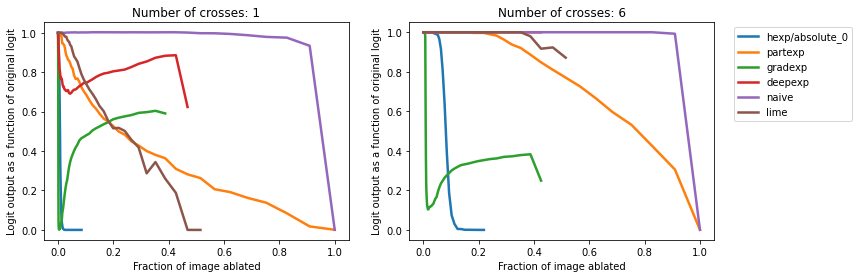

In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import torch
from PIL import Image
from tqdm import tqdm

# exp_x = np.linspace(-1, 0, 20)
# perturbation_sizes = np.sort(1.1 - 10 ** (exp_x))
A = 100*120
exp_x = np.linspace(np.log10(1/A), 0, 100)
relative_perturbation_sizes = np.concatenate(([0], np.sort(10 ** (exp_x))))
exp_mapper = ["hexp/absolute_0", "partexp", "gradexp", "deepexp", "naive", "lime"]

c = [1, 6]
fig = plt.figure(figsize=(12, 4))
axes = fig.subplots(1, 2)
for exp_name in exp_mapper:
    for j, n in enumerate(c):
        LOR = np.load(os.path.join("LOR", "%s/results_%d.npy" % (exp_name, n)))
        drop = []
        # for i, p in enumerate(relative_perturbation_sizes):
        #     c = LOR[:, i]
        #     nonzero_ids = np.where(c != 0)
        #     nonzero_c = c[nonzero_ids]
        #     drop.append(np.median(nonzero_c))
        ax = axes[j]
        # ax.plot(relative_perturbation_sizes, np.mean(LOR, axis=0), label=exp_name)
        abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
        ax.plot(relative_perturbation_sizes, abl_curve, label=exp_name, lw=2.5)
        # ax.plot(relative_perturbation_sizes, np.log10(6.6363e-04) * np.ones(len(relative_perturbation_sizes)), '-.k')    
        # ax.set_xscale("log")
        ax.set_xlabel("Fraction of image ablated")
        ax.set_ylabel("Logit output as a function of original logit")
        ax.set_title("Number of crosses: %d" % n)
        if j == len(c)-1:
            ax.legend(bbox_to_anchor=(1.05, 1))      
plt.savefig("LOR.eps")

100%|██████████| 300/300 [00:01<00:00, 153.79it/s]


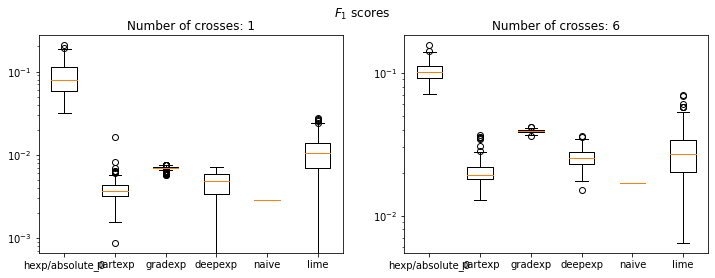

In [2]:
c = [1, 6]
true_positives = np.load("true_positives.npy", allow_pickle=True)

fig = plt.figure(figsize=(12, 4))
axes = fig.subplots(1, 2)
figure = "f1_scores"

for j, n in enumerate(c):
    data = []
    for exp_name in exp_mapper:
        explanation_dir = os.path.join("true_positive_explanations", exp_name)
        scores = []
        for image_path in tqdm(true_positives.item()[str(n)]):
            image = Image.open(image_path)
            image_name = os.path.basename(image_path)
            image_id = int(image_name.split("_")[1].split(".")[0])
            # print(image_name, image_id)
            ground_truth = np.zeros((100, 120))
            positions = np.load("/export/gaon1/data/jteneggi/data/synthetic/LOR/ground_truth/%d/ex%d_%d.npy" % (n, n, image_id))
            # print(positions)
            for position in positions:
                top_left = position[0]
                bottom_right = position[1]
                for k in range(9):
                    ground_truth[top_left[1]+k, top_left[0]+k] = 1
                    ground_truth[bottom_right[1]-k, top_left[0]+k] = 1
                # ground_truth[top_left[1]:bottom_right[1]+1, top_left[0]:bottom_right[0]+1] = 1
            # axes[0].imshow(ground_truth)
            if exp_name == "naive":
                explanation = torch.rand(100, 120, device=torch.device("cpu")) + .5
            else:
                explanation = np.load(os.path.join(explanation_dir, "%s.npy" % image_name))
            score = metrics.f1_score(ground_truth.flatten(), explanation.flatten() > 0)
            scores.append(score)
            # axes[1].imshow(explanation)
        data.append(scores)
    ax = axes[j]
    ax.set_title("Number of crosses: %d" % n)
    if figure == "f1_scores":
        ax.boxplot(data, labels=exp_mapper)
        ax.set_yscale("log")
    elif figure == "comp_times":
        comp_times = np.load(os.path.join("true_positive_explanations", f"comp_times_{n}.npy"), allow_pickle=True).item()
        for exp_name, scores in zip(exp_mapper, data):
            median_f1 = np.median(scores)
            if exp_name != "naive":
                if "hexp" in exp_name:
                    mode_name = exp_name.split("/")[1]
                    cum_comp_time = comp_times["hexp"][mode_name]
                else:
                    cum_comp_time = comp_times[exp_name]
                mean_comp_time = cum_comp_time / len(true_positives.item()[str(n)])
                ax.scatter(mean_comp_time, median_f1, label=exp_name)
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_xlabel("Mean computation time (s)")
        ax.set_ylabel("Mean f1 score")
        ax.set_ylim([1e-3, 5e-1])
        ax.set_xlim([1e-2, 1e1])
        ax.set_xlim([1e-2, 1e-2,])
        ax.set_yticks([1e-3, 1e-2, 1e-1])
        if j == len(c) - 1:
            ax.legend(bbox_to_anchor=(1.05, 1))      
if figure == "f1_scores":
    fig.suptitle(r"$F_1$ scores")
    plt.savefig("f1_scores.eps")
else:
    plt.savefig("f1_versus_time.eps")